In [1]:
from chop.tools import get_tokenized_dataset

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True
)

/rds/general/user/oa321/home/miniforge3/envs/mase_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


In [2]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools import get_trainer

config = AutoConfig.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_config(config)

trainer = get_trainer(
    model = model,
    tokenized_dataset = dataset,
    tokenizer = tokenizer,
    evaluate_metric = "accuracy",
    num_train_epochs = 1
)

trainer.train()

eval_results = trainer.evaluate()

baseline = eval_results["eval_accuracy"]
print(baseline)


/rds/general/user/oa321/home/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693800
1000,0.637500
1500,0.464200
2000,0.404200
2500,0.373000
3000,0.378700


0.84448


In [3]:
import torch.nn as nn
from chop.nn.modules import Identity

search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices" : ["linear", "identity"]
}


In [4]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr

track = set({})

def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)
    ss_template = search_space

    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size"
    ]:
        chosen_idex = trial.suggest_int(param, 0, len(ss_template[param]) - 1)
        setattr(config, param, ss_template[param][chosen_idex])

    trial_model = AutoModelForSequenceClassification.from_config(config)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            track.add(name)
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                ss_template["linear_layer_choices"],
            )

            if new_layer_cls == "linear":
                continue
            elif new_layer_cls == "identity":
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unkown layer type: {new_layer_cls}")

    return trial_model

In [5]:
from chop.tools import get_trainer

def objective(trial):
    model = construct_model(trial)

    trainer = get_trainer(
        model = model,
        tokenized_dataset = dataset,
        tokenizer = tokenizer,
        evaluate_metric = "accuracy",
        num_train_epochs = 1
    )

    trainer.train()

    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

In [6]:
import optuna
from optuna.samplers import GridSampler, RandomSampler, TPESampler

def getGridSearchSpace():
    grid_search_space = {
        "num_layers": [i for i in range(0, len(search_space['num_layers']))],
        "num_heads": [i for i in range(0, len(search_space['num_heads']))],
        "hidden_size": [i for i in range(0, len(search_space['hidden_size']))],
        "intermediate_size": [i for i in range(0, len(search_space['intermediate_size']))],
    }

    sampler = RandomSampler()

    study = optuna.create_study(
        direction="maximize",
        study_name="bert-tiny-nas-study",
        sampler=sampler
    )

    study.optimize(
        lambda trial: construct_model(trial=trial),
        n_trials = 100,
        timeout=60*60*24
    )

    for name in track :
        grid_search_space[f'{name}_type'] = ["linear", "identity"]

    return grid_search_space


In [24]:
# sampler = GridSampler(search_space=getGridSearchSpace()) # The sampler to use below
sampler = RandomSampler()
# sampler = TPESampler()

In [8]:
study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler
)

study.optimize(
    objective,
    n_trials = 1,
    timeout=60*60*24
)

[I 2025-02-02 22:29:05,475] A new study created in memory with name: bert-tiny-nas-study
/rds/general/user/oa321/home/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.651100
1000,0.478600
1500,0.416100
2000,0.366000
2500,0.333200
3000,0.340600


[I 2025-02-02 22:30:34,467] Trial 0 finished with value: 0.86304 and parameters: {'num_layers': 2, 'num_heads': 1, 'hidden_size': 3, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': 'linear', 'bert.encoder.layer.0.attention.self.key_type': 'linear', 'bert.encoder.layer.0.attention.self.value_type': 'linear', 'bert.encoder.layer.0.attention.output.dense_type': 'identity', 'bert.encoder.layer.1.attention.self.query_type': 'identity', 'bert.encoder.layer.1.attention.self.key_type': 'linear', 'bert.encoder.layer.1.attention.self.value_type': 'identity', 'bert.encoder.layer.1.attention.output.dense_type': 'identity', 'bert.pooler.dense_type': 'identity'}. Best is trial 0 with value: 0.86304.


In [9]:
from pathlib import Path
import dill

model = study.best_trial.user_attrs["model"].cpu()

with open(f"{Path.home()}/mase/tasks/tutorial5/t5_best_model.pkl", "wb") as f:
    dill.dump(model, f)

In [32]:
from chop.pipelines import CompressionPipeline
from chop import MaseGraph

mg = MaseGraph(model)
pipe = CompressionPipeline()

quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

mg, _ = pipe(
    mg,
    pass_args={
        "quantize_transform_pass": quantization_config,
        "prune_transform_pass": pruning_config,
    },
)

INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


In [16]:
import pandas as pd
from optuna import Study
from optuna.trial import FrozenTrial

def samplerTrial(sampler_name:str, trials:int, sampler, f=objective) -> None:

    data = [0]*trials

    def record_accuracy_callback(stud:Study, fzt:FrozenTrial):
        print(f"Trial: {fzt.number}, Accuracy: {fzt.value}")
        data[fzt.number-1] ={"n":fzt.number, "accuracy":fzt.value}

    if (sampler == None):
        raise RuntimeError("No Sampler Provided")

    study = optuna.create_study(
        direction="maximize",
        study_name=f"bert-tiny-nas-{sampler_name}-study",
        sampler=sampler
    )

    study.optimize(
        f,
        n_trials=trials,
        timeout=60*60*24,
        callbacks=[record_accuracy_callback]
    )

    df = pd.DataFrame(data)
    df.to_csv(f"{Path.home()}/mase/tasks/tutorial5/sampler_run_{sampler_name}.csv", index=False)


In [12]:
# samplerTrial(sampler_name="grid", trials=100, sampler=sampler)

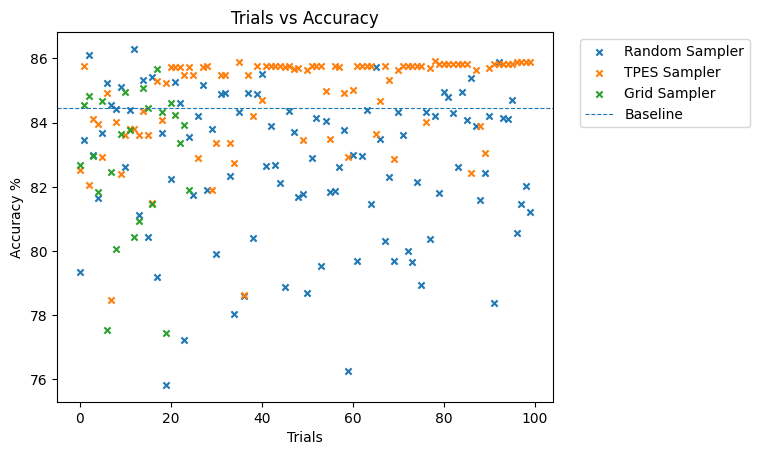

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

df_r = pd.read_csv(f"{Path.home()}/mase/tasks/tutorial5/random.csv")
df_t = pd.read_csv(f"{Path.home()}/mase/tasks/tutorial5/tpes.csv")
df_g = pd.read_csv(f"{Path.home()}/mase/tasks/tutorial5/grid.csv")
fig_pretrain = plt.figure()

plt.scatter(x=df_r['n'], y=df_r['accuracy'] * 100, marker='x', s=20)
plt.scatter(x=df_t['n'], y=df_t['accuracy'] * 100, marker='x', s=20)
plt.scatter(x=df_g['n'], y=df_g['accuracy'] * 100, marker='x', s=20)
plt.axhline(y=baseline * 100, linestyle='--', linewidth=0.8)
plt.legend(['Random Sampler', 'TPES Sampler', 'Grid Sampler', 'Baseline'], bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("Trials")
plt.ylabel("Accuracy %")
plt.title("Trials vs Accuracy")
plt.savefig(f"{Path.home()}/mase/tasks/tutorial5/samplers")
plt.show()

In [33]:
def train(model):

    trainer = get_trainer(
        model = model,
        tokenized_dataset = dataset,
        tokenizer = tokenizer,
        evaluate_metric = "accuracy",
        num_train_epochs = 1
    )

    trainer.train()

    eval_results = trainer.evaluate()

    return eval_results["eval_accuracy"]


def pipeObjective(trial):
    model = construct_model(trial)

    post_t1 = train(model)
    print(f'Post Train: {post_t1}')

    model.cpu()

    mg = MaseGraph(model=model)

    qc = quantization_config
    pc = pruning_config

    mg, _ = pipe(
            mg,
            pass_args={
                "quantize_transform_pass": qc,
                "prune_transform_pass": pc,
            }
        )

    trainer = get_trainer(
        model = model,
        tokenized_dataset = dataset,
        tokenizer = tokenizer,
        evaluate_metric = "accuracy",
        num_train_epochs = 1
    )

    post_comp_no_t = trainer.evaluate()

    print(f'Post Compressing: {post_comp_no_t}')

    trainer.train()

    eval_results = trainer.evaluate()

    print(f'Final: {eval_results["eval_accuracy"]}')

    trial.set_user_attr("model", mg.model)

    return eval_results["eval_accuracy"]

In [34]:

study = optuna.create_study(
    direction="maximize",
    study_name=f"bert-tiny-nas-study",
    sampler=sampler
)

study.optimize(
    pipeObjective,
    n_trials=1,
    timeout=60*60*24
)


[I 2025-02-02 23:10:21,514] A new study created in memory with name: bert-tiny-nas-study
/rds/general/user/oa321/home/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.688300
1000,0.561600
1500,0.483500
2000,0.414800
2500,0.365300
3000,0.362200


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


Post Train: 0.85004


[W 2025-02-02 23:11:36,530] Trial 0 failed with parameters: {'num_layers': 1, 'num_heads': 1, 'hidden_size': 2, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': 'identity', 'bert.encoder.layer.0.attention.self.key_type': 'identity', 'bert.encoder.layer.0.attention.self.value_type': 'linear', 'bert.encoder.layer.0.attention.output.dense_type': 'identity', 'bert.encoder.layer.1.attention.self.query_type': 'linear', 'bert.encoder.layer.1.attention.self.key_type': 'linear', 'bert.encoder.layer.1.attention.self.value_type': 'identity', 'bert.encoder.layer.1.attention.output.dense_type': 'linear', 'bert.pooler.dense_type': 'linear'} because of the following error: KeyError('by').
Traceback (most recent call last):
  File "/rds/general/user/oa321/home/miniforge3/envs/mase_env/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/tmp/pbs.566831.pbs/ipykernel_9750

tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

KeyError: 'by'